# Taylor Factor Calculation for Uniaxial Loading of FCC Polycrystal

This notebook computes the Taylor factor M for:
- a single FCC crystal with a given orientation [1 0 0]
- a polycrystal by averaging many random crystal orientations

**Assumptions:**
- Slip systems: FCC {111}<110>
- Plastic deformation only by slip
- Uniaxial loading in x-direction (isochoric):
      eps_macro = diag(1, -0.5, -0.5)

**Taylor factor definition:**
    M = sum(|gamma_s|) / eps11

where gamma_s are the slip shear rates solving:
    eps_macro = Σ gamma_s * P_s  (P_s = sym(m ⊗ n))

**How to use:**
1. Run the cell below.
2. Modify `N_grains` to average over an increasing number of randomly oriented grains. This yield the average polycrystalline Taylor factor, as well as a distribution of the individual factor of the grains.


In [66]:
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt

In [67]:
# ============================================================
# 1. FCC slip systems generator
# ============================================================

# FCC slip systems {111}<110>
#
# We define:
# - plane normals n (unit vectors)
# - slip directions m (in-plane, m·n = 0)
#
# FCC has 12 slip systems: 4 {111} planes × 3 <110> directions each.

def get_fcc_slip_systems():
    """
    Generate the standard 12 FCC {111}<110> slip systems (m, n) in crystal coordinates.

    Returns
    -------
    systems_normed : list of (m, n)
        m and n are normalized (unit vectors). These are used in the Taylor calculation.
    systems : list of (m, n)
        Original integer [hkl] and [uvw] vectors (not normalized), for printing / checking.

    Idea
    ----
    1. Start from the 4 distinct {111} plane normals.
    2. Generate all <110> direction vectors.
    3. For each plane, pick the directions that lie in the plane (m·n = 0).
    4. For each ± pair of directions, keep only one (they represent the same slip direction).
    """
    # Four distinct {111} planes (±n represent the same plane)
    plane_normals = [
        np.array([ 1,  1,  1], dtype=float),
        np.array([ 1,  1, -1], dtype=float),
        np.array([ 1, -1,  1], dtype=float),
        np.array([-1,  1,  1], dtype=float),
    ]

    # Build all <110> directions: permutations of (±1, ±1, 0)
    # This gives 12 directions, including positive and negative variants.
    dirs = []
    for a in [-1, 1]:
        for b in [-1, 1]:
            dirs.append(np.array([a, b, 0.0]))
            dirs.append(np.array([a, 0.0, b]))
            dirs.append(np.array([0.0, a, b]))

    # Remove duplicates (just in case)
    unique_dirs = []
    for v in dirs:
        if not any(np.all(v == w) for w in unique_dirs):
            unique_dirs.append(v)
    dirs = unique_dirs

    systems = []          # will store the original integer directions (m, n)
    systems_normed = []   # will store the normalized directions (m, n)

    # Loop over each {111} plane normal
    for n in plane_normals:
        n_norm = n / np.linalg.norm(n)   # normalize plane normal

        # All <110> directions with m·n = 0 (m lies in this {111} plane)
        inplane = [m for m in dirs if abs(np.dot(m, n)) < 1e-6]

        # Collapse ± pairs: pick a "canonical" direction from each ± pair.
        # For each pair {m, -m}, we keep only one representative.
        chosen = []
        for m in inplane:
            # We'll keep m if it is lexicographically >= -m.
            # This is just a trick to choose one from {m, -m}.
            if tuple(m) < tuple(-m):
                continue  # then -m is the canonical representative
            chosen.append(m)

        # For FCC, there should be exactly 3 in-plane <110> directions per {111} plane.
        for m in chosen:
            m_norm = m / np.linalg.norm(m)      # normalize slip direction
            systems_normed.append((m_norm, n_norm))
            systems.append((m, n))

    return systems_normed, systems


# Get the normalized slip systems for use in the Taylor factor calculation
slip_systems_crystal = get_fcc_slip_systems()[0]  # (m, n) in crystal frame, unit vectors
# Get the integer Miller indices for printing
slip_systems = get_fcc_slip_systems()[1]

print("Number of FCC slip systems:", len(slip_systems_crystal))

print("\nPlane(hkl)   Direction[uvw] \n---------------------------")
for s in slip_systems:
    # s[0] is m (direction), s[1] is n (plane normal)
    uvw = s[0]
    hkl = s[1]
    print(
        f"({hkl[0]:.0f},{hkl[1]:.0f},{hkl[2]:.0f})   "
        f"[{uvw[0]:.0f},{uvw[1]:.0f},{uvw[2]:.0f}]   "
    )

Number of FCC slip systems: 12

Plane(hkl)   Direction[uvw] 
---------------------------
(1,1,1)   [1,-1,0]   
(1,1,1)   [1,0,-1]   
(1,1,1)   [0,1,-1]   
(1,1,-1)   [1,-1,0]   
(1,1,-1)   [1,0,1]   
(1,1,-1)   [0,1,1]   
(1,-1,1)   [1,0,-1]   
(1,-1,1)   [1,1,0]   
(1,-1,1)   [0,1,1]   
(-1,1,1)   [0,1,-1]   
(-1,1,1)   [1,1,0]   
(-1,1,1)   [1,0,1]   


In [68]:
# ============================================================
# 2. Euler angles → rotation matrix (Bunge convention)
# ============================================================

# Bunge convention:
#     g = R_z(phi1) · R_x(Phi) · R_z(phi2)
#
# The rotation matrix g transforms vectors from the crystal reference frame
# to the sample (loading) reference frame.

def rotation_matrix_from_euler_bunge(phi1, Phi, phi2, degrees=True):
    """
    Return rotation matrix g using Bunge Euler angles (phi1, Phi, phi2).

    Parameters
    ----------
    phi1, Phi, phi2 : floats
        Bunge Euler angles defining the crystal orientation.
    degrees : bool
        If True, input angles are in degrees and will be converted to radians.

    Returns
    -------
    g : (3x3) numpy array
        Rotation matrix from crystal frame to sample frame.
    """
    if degrees:
        phi1 = np.deg2rad(phi1)
        Phi  = np.deg2rad(Phi)
        phi2 = np.deg2rad(phi2)

    # Rotation about z-axis
    def R_z(a):
        c, s = np.cos(a), np.sin(a)
        return np.array([[c, -s, 0],
                         [s,  c, 0],
                         [0,  0, 1]])

    # Rotation about x-axis
    def R_x(a):
        c, s = np.cos(a), np.sin(a)
        return np.array([[1, 0,  0],
                         [0, c, -s],
                         [0, s,  c]])

    # Bunge convention: g = R_z(phi1) * R_x(Phi) * R_z(phi2)
    return R_z(phi1) @ R_x(Phi) @ R_z(phi2)

In [69]:
# ==============================================
# 3. Build linear system: eps_macro = A * gamma
# ==============================================

# Each slip system contributes a shear strain tensor:
#     P_s = 0.5 (m ⊗ n + n ⊗ m)
#
# The macroscopic plastic strain is:
#     eps_macro = Σ gamma_s * P_s
#
# For the linear programming solver, we represent symmetric tensors as 6-vectors:
#     [e11, e22, e33, e12, e13, e23]
#
# Then we can write:
#     eps_vec = A * gamma
# where A is a 6 × Ns matrix (Ns = number of slip systems).

def sym_tensor_to_vec(E):
    """
    Convert a symmetric 3×3 strain tensor E into a 6-component vector:
    [E11, E22, E33, E12, E13, E23].
    """
    return np.array([
        E[0, 0],
        E[1, 1],
        E[2, 2],
        E[0, 1],
        E[0, 2],
        E[1, 2],
    ])


def build_A_matrix(slip_systems_sample):
    """
    Build the matrix A (6 × Ns) that relates slip rates gamma_s to the macroscopic strain.

    Parameters
    ----------
    slip_systems_sample : list of (m, n)
        Slip directions and plane normals in the sample frame.

    Returns
    -------
    A : (6 × Ns) numpy array
        Column s corresponds to the contribution of slip system s to the strain vector.
    """
    Ns = len(slip_systems_sample)
    A = np.zeros((6, Ns))

    for s, (m, n) in enumerate(slip_systems_sample):
        # P_s = 0.5 (m ⊗ n + n ⊗ m) is the symmetric shear strain from slip system s
        P = 0.5 * (np.outer(m, n) + np.outer(n, m))
        # Convert P to 6-vector and store in column s
        A[:, s] = sym_tensor_to_vec(P)

    return A

In [70]:
# ============================================================================
# 4. Taylor minimization (L1) using linear programming to solve for slip shear
# ============================================================================

# We want to minimize the total shear (sum of absolute slip rates):
#     minimize Σ |γ_s|
# subject to:
#     A * γ = eps_macro
#
# This corresponds to Taylor's assumption of homogeneous strain with
# minimum total shear in the grains.
#
# We solve this with linear programming by splitting
#     γ_s = γ_s⁺ − γ_s⁻,  with γ_s⁺ ≥ 0, γ_s⁻ ≥ 0,
# and minimizing Σ (γ_s⁺ + γ_s⁻).

def solve_taylor_minimization(A, eps_vec):
    """
    Solve for the slip rates gamma_s by minimizing Σ|gamma_s| using linear programming.

    Parameters
    ----------
    A : (6 × Ns) numpy array
        Strain contribution matrix.
    eps_vec : (6,) numpy array
        Macroscopic strain vector (flattened).

    Returns
    -------
    gamma : (Ns,) numpy array
        Slip rates for each slip system that minimize total shear.
    """
    Ns = A.shape[1]

    # LP variable vector x = [gamma_plus (Ns), gamma_minus (Ns)]
    # Objective: minimize sum of gamma_plus and gamma_minus
    c = np.ones(2 * Ns)

    # Equality constraints: A * (gamma_plus - gamma_minus) = eps_vec
    A_eq = np.hstack((A, -A))
    b_eq = eps_vec

    # Bounds: gamma_plus >= 0, gamma_minus >= 0 (no upper bound)
    bounds = [(0, None)] * (2 * Ns)

    # Solve linear program using SciPy's 'highs' solver
    res = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method="highs")

    if not res.success:
        raise RuntimeError("LP did not converge: " + res.message)

    x = res.x
    # Extract gamma_plus and gamma_minus from the solution
    gamma_plus, gamma_minus = x[:Ns], x[Ns:]

    # Physical slip rate gamma_s = gamma_plus - gamma_minus
    return gamma_plus - gamma_minus

In [71]:
# ============================================================
# 5. Compute Taylor factor for a single orientation
# ============================================================

# Steps:
# 1. Build rotation matrix g from Euler angles.
# 2. Rotate slip systems from crystal frame to sample frame.
# 3. Build A matrix from slip systems in sample frame.
# 4. Solve the linear program to get slip rates gamma_s.
# 5. Compute Taylor factor M = Σ|γ_s| / ε₁₁.

def taylor_factor_for_orientation(phi1, Phi, phi2, degrees=True):
    """
    Compute Taylor factor M for a single FCC crystal orientation.

    Parameters
    ----------
    phi1, Phi, phi2 : floats
        Bunge Euler angles of the crystal.
    degrees : bool
        If True, angles are given in degrees.

    Returns
    -------
    M : float
        Taylor factor for this orientation under uniaxial tension in x.
    gamma : (Ns,) numpy array
        Slip rates on each slip system.
    """
    # Rotation matrix from crystal to sample frame
    g = rotation_matrix_from_euler_bunge(phi1, Phi, phi2, degrees)

    # Rotate each slip system (m, n) into the sample frame: m' = g m, n' = g n
    slip_systems_sample = [(g @ m, g @ n) for (m, n) in slip_systems_crystal]

    # Build A matrix for these slip systems
    A = build_A_matrix(slip_systems_sample)

    # Isochoric uniaxial tension along x:
    # eps11 = +1, eps22 = eps33 = -0.5 (to keep volume constant: trace = 0)
    eps_macro = np.array([[ 1.0,  0.0,  0.0],
                          [ 0.0, -0.5,  0.0],
                          [ 0.0,  0.0, -0.5]])
    eps_vec = sym_tensor_to_vec(eps_macro)

    # Solve for slip rates gamma_s
    gamma = solve_taylor_minimization(A, eps_vec)

    # Taylor factor: total shear divided by axial strain ε11
    M = np.sum(np.abs(gamma)) / eps_macro[0, 0]  # ε11 = 1

    return M, gamma

In [72]:
# ============================================================
# Example: Single crystal with [100] // loading direction
# ============================================================
#
# For this orientation, the sample x-axis aligns with the crystal [100] direction.
# This corresponds to Euler angles (phi1, Phi, phi2) = (0, 0, 0).

M_100, gamma_100 = taylor_factor_for_orientation(0, 0, 0)
print(f"Taylor factor for [100] crystal: M = {M_100:.3f}")

# --------------------------------------------
# Identify and print activated slip systems
# --------------------------------------------

print("\nActivated slip systems for [100] // tension direction:")
print("--------------------------------------------------------")
print("plane       direction   gamma_s")

# slip_systems: list of (m_int, n_int) integer vectors
# gamma_100: slip rates for each system in the example

for i, gamma_s in enumerate(gamma_100):
    if abs(gamma_s) > 1e-12:
        m_int, n_int = slip_systems[i]   # integer slip direction and plane normal
        print(f"({n_int[0]:.0f} {n_int[1]:.0f} {n_int[2]:.0f})    "
              f"[{m_int[0]:.0f} {m_int[1]:.0f} {m_int[2]:.0f}]     "
              f"{gamma_s:.4f}")

Taylor factor for [100] crystal: M = 2.449

Activated slip systems for [100] // tension direction:
--------------------------------------------------------
plane       direction   gamma_s
(1 1 -1)    [1 0 1]     0.6124
(1 -1 1)    [1 1 0]     0.6124
(-1 1 1)    [1 1 0]     -0.6124
(-1 1 1)    [1 0 1]     -0.6124


In [73]:
# ============================================================
# 6. Random polycrystal simulation
# ============================================================

# To approximate a random polycrystal, we:
# - generate many random crystal orientations (uniform on SO(3))
# - compute the Taylor factor M for each grain
# - take the average M over all grains

def random_euler_angles_uniform_SO3(num, degrees=True):
    """
    Generate 'num' random Bunge Euler angles (phi1, Phi, phi2)
    that are uniformly distributed over all possible orientations (SO(3)).

    Method:
      - phi1 ~ U(0, 2π)
      - phi2 ~ U(0, 2π)
      - cos(Phi) ~ U(-1, 1)  → ensures p(Phi) ∝ sin(Phi), i.e. uniform on the sphere.
    """
    rng = np.random.default_rng()

    # Uniform in [0, 2π) for rotations about z
    phi1 = rng.uniform(0.0, 2.0 * np.pi, num)
    phi2 = rng.uniform(0.0, 2.0 * np.pi, num)

    # cos(Phi) uniform in [-1, 1]
    u = rng.uniform(-1.0, 1.0, num)
    Phi = np.arccos(u)   # Phi in [0, π]

    if degrees:
        phi1 = np.rad2deg(phi1)
        Phi  = np.rad2deg(Phi)
        phi2 = np.rad2deg(phi2)

    return phi1, Phi, phi2


def taylor_factor_polycrystal(num_grains=1000):
    """
    Compute the mean Taylor factor for a random FCC polycrystal.

    Parameters
    ----------
    num_grains : int
        Number of grains (orientations) to simulate.

    Returns
    -------
    M_mean : float
        Average Taylor factor over all grains.
    M_list : (num_grains,) numpy array
        Taylor factor for each grain.
    """
    # Generate random orientations
    phi1_list, Phi_list, phi2_list = random_euler_angles_uniform_SO3(num_grains, degrees=True)

    M_list = []
    # Loop over grains and compute M for each orientation
    for phi1, Phi, phi2 in zip(phi1_list, Phi_list, phi2_list):
        M, _ = taylor_factor_for_orientation(phi1, Phi, phi2, degrees=True)
        M_list.append(M)

    M_list = np.array(M_list)
    return np.mean(M_list), M_list

Mean Taylor factor for random FCC polycrystal: 3.077
Range: min=2.284, max=3.674



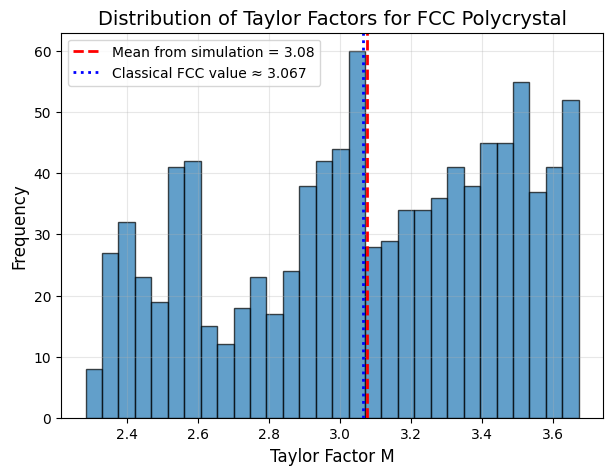

In [74]:
# ============================================================
# Run: Polycrystal with N grains (e.g. 1000)
# ============================================================

# This gives a numerical estimate of the classical Taylor factor
# for an FCC polycrystal in uniaxial tension.

N_grains=1000 # <--- User-defined number of grains

M_mean, M_list = taylor_factor_polycrystal(N_grains) 
print(f"Mean Taylor factor for random FCC polycrystal: {M_mean:.3f}")
print(f"Range: min={M_list.min():.3f}, max={M_list.max():.3f}\n")

# -------------------------------------------------------------
# Plot distribution of Taylor factors for the random polycrystal
# -------------------------------------------------------------

plt.figure(figsize=(7,5))

# Histogram of the Taylor factors
plt.hist(M_list, bins=30, edgecolor='black', alpha=0.7)

# Plot the numerical mean from simulation
plt.axvline(M_mean, color='red', linestyle='--', linewidth=2,
            label=f"Mean from simulation = {M_mean:.2f}")

# Classical Taylor factor for FCC polycrystals (~3.06)
plt.axvline(3.067, color='blue', linestyle=':', linewidth=2,
            label="Classical FCC value ≈ 3.067")

plt.xlabel("Taylor Factor M", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Taylor Factors for FCC Polycrystal", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)

plt.show()